In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def load_dic_file(filename):
    with open(filename, 'r') as f:
        content = f.readlines()
    df = pd.DataFrame([[float(j) for j in i.split("\t")] for i in content[1:]])
    df = df.rename({0: "X-Position", 1: "Y-Position", 2: "U-Displacement", 3: "V-Displacement"}, axis=1)
    return df

def extract_displacement_jump(df, interface_x=650):
    df_filtered = df[(df['U-Displacement'] != 0) & (df['V-Displacement'] != 0)]
    
    left_region = df_filtered[df_filtered['X-Position'] < interface_x]
    right_region = df_filtered[df_filtered['X-Position'] > interface_x + 50]  # Avoid interface zone
    
    # Average vertical displacement near interface from left and right
    left_avg_v = left_region['V-Displacement'].mean()
    right_avg_v = right_region['V-Displacement'].mean()
    
    # Displacement jump at interface
    delta_v = np.abs(left_avg_v - right_avg_v)
    return delta_v

In [2]:
# Load all files
file_pattern = "DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B*.txt"
files = sorted(glob.glob(file_pattern))
files

['DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00001.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00002.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00003.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00004.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00005.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00006.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00007.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00008.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00009.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00010.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00011.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00012.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00013.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00014.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00015.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/B00016.txt',
 'DIC_Data/Normal/R1_CAFS13/R1_Loading_S

In [3]:
df1 = load_dic_file(files[0])
df1

,X-Position,Y-Position,U-Displacement,V-Displacement
0,16.0,16.0,18.6507,-0.308418
1,48.0,16.0,18.2090,-0.602287
2,80.0,16.0,14.1088,-1.770360
3,112.0,16.0,13.8437,-1.979270
4,144.0,16.0,13.9597,-2.043350
...,...,...,...,...
1275,1136.0,1008.0,12.6465,-2.095250
1276,1168.0,1008.0,12.6338,-2.081150
1277,1200.0,1008.0,12.6341,-2.090960
1278,1232.0,1008.0,12.6592,-2.078210


In [4]:
loadings_df = pd.read_excel("DIC_Data/Normal/R1_CAFS13/R1_Loading_SumDiff/CAFS13_NormalLoading.xlsx").drop(columns=1.00)
loadings_df = loadings_df.rename({0.17: "Loading"}, axis=1)
Loadings = list(loadings_df["Loading"])

In [5]:
displacement_jumps = []
for i, file in enumerate(files):
    df = load_dic_file(file)
    delta_v = extract_displacement_jump(df)
    displacement_jumps.append(delta_v)

displacement_jumps[:5]

[np.float64(0.09469906810809015),
 np.float64(0.15588858004653128),
 np.float64(0.2609449943963842),
 np.float64(0.3050906518862906),
 np.float64(0.2630385647698592)]

In [6]:
# Create DataFrame for plotting
data = pd.DataFrame({
    'Applied Load (N)': Loadings[:len(displacement_jumps)],
    'Displacement Jump (pixels)': displacement_jumps
})


In [7]:
data

,Applied Load (N),Displacement Jump (pixels)
0,0.372,0.094699
1,0.651,0.155889
2,0.831,0.260945
3,0.996,0.305091
4,1.249,0.263039
5,1.496,0.293091
6,1.748,0.414577
7,2.010,0.529548
8,2.246,0.619438
9,2.510,0.684523


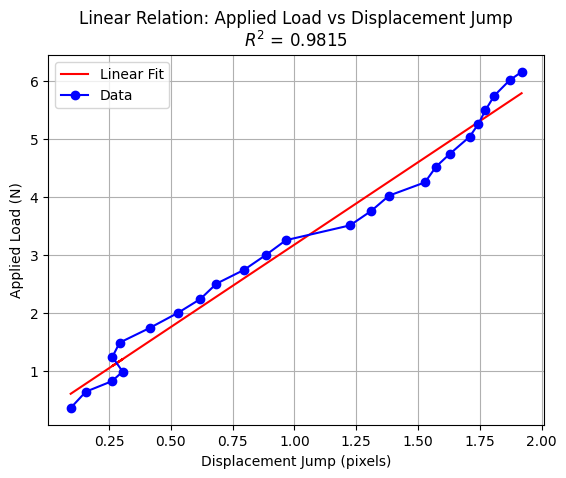

In [46]:
coeffs = np.polyfit(data["Displacement Jump (pixels)"], data["Applied Load (N)"], 1)
p = np.poly1d(coeffs)


y_true = data["Applied Load (N)"]
y_pred = p(data["Displacement Jump (pixels)"])
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r_squared = 1 - (ss_res / ss_tot)

def line_eqn(x, coeffs):
    return coeffs[0] * x + coeffs[1]

straight_line = [line_eqn(x, coeffs) for x in data["Displacement Jump (pixels)"]]
plt.plot(data["Displacement Jump (pixels)"], straight_line, 'r-', label='Linear Fit')
plt.plot(data["Displacement Jump (pixels)"], data["Applied Load (N)"], "bo-", label='Data')
plt.grid(True)
plt.xlabel('Displacement Jump (pixels)')
plt.ylabel('Applied Load (N)')
plt.title(f'Linear Relation: Applied Load vs Displacement Jump\n$R^2$ = {r_squared:.4f}')
plt.legend()
plt.show()



linear or nonlinear behavior depending on surface and material properties.

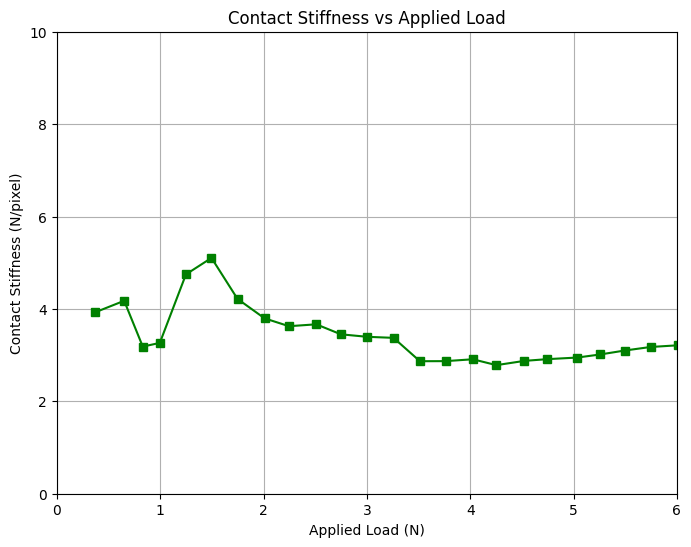

In [33]:
data['Contact Stiffness (N/pixel)'] = data['Applied Load (N)'] / data['Displacement Jump (pixels)']
plt.figure(figsize=(8,6))
plt.plot(data['Applied Load (N)'], data['Contact Stiffness (N/pixel)'], 'gs-')
plt.xlabel('Applied Load (N)')
plt.ylabel('Contact Stiffness (N/pixel)')
plt.title('Contact Stiffness vs Applied Load')
plt.grid(True)
plt.axis([0,6,0,10])
plt.show()

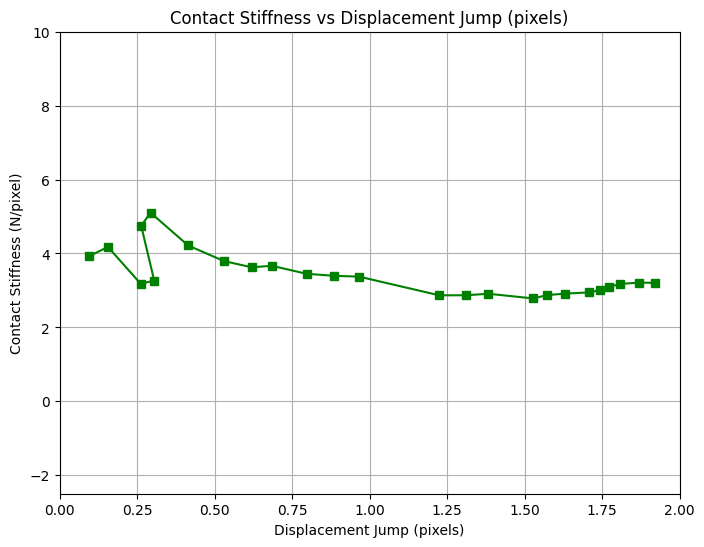

In [52]:
plt.figure(figsize=(8,6))
plt.plot(data['Displacement Jump (pixels)'], data['Contact Stiffness (N/pixel)'], 'gs-')
plt.xlabel('Displacement Jump (pixels)')
plt.ylabel('Contact Stiffness (N/pixel)')
plt.title('Contact Stiffness vs Displacement Jump (pixels)')
plt.grid(True)
plt.axis([0,2,-2.5,10])
plt.show()